<a href="https://colab.research.google.com/github/enznoor/AnomalyDetection/blob/main/FIP_Libra_FinalMyModel_SiameseNetwork_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dgl
!pip install node2vec
!pip install -q torch-geometric

In [ ]:
from node2vec.edges import HadamardEmbedder
from gensim.models import Word2Vec
import random
from node2vec import Node2Vec
from gensim.models import KeyedVectors
import torch.optim as optim
import dgl.function as fn
from dgl.nn import SAGEConv

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
from google.colab import drive
import networkx as nx
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
#from dgl.nn import GraphConv
#from dgl.nn import SAGEConv
from torch_geometric.nn import GATConv
import dgl.nn as dglnn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score , roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc
import torch_geometric

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
seed=42
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
path='drive/MyDrive/Term_05/FinalProposal/Data/'
Finalpath='drive/MyDrive/Term_05/FinalProposal/FinalData/'
Finalpath_test='drive/MyDrive/Term_05/FinalProposal/FinalData_test/'
pathCommunity='drive/MyDrive/Term_05/FinalProposal/Data/Community/'
train_edge_index=np.load(path+'train_edge_index.npy')
train_edgelist=np.load(path+'train_edgelist.npy')
train_edge_weight=np.load(path+'train_edge_weight.npy')
train_x=np.load(path+'train_x.npy')
train_y=np.load(path+'train_y.npy')
test_edge_index=np.load(path+'test_edge_index.npy')
test_edgelist=np.load(path+'test_edgelist.npy')
test_edge_weight=np.load(path+'test_edge_weight.npy')
test_x=np.load(path+'test_x.npy')
test_y=np.load(path+'test_y.npy')
train_elabel=np.load(path+'edge_y_train.npy')
test_elabel=np.load(path+'edge_y_test.npy')

In [ ]:
nodedf=pd.read_csv(path + 'LibraReduceNodeInfo.csv')
edgedf=pd.read_csv(path + 'LibraReduceEdgeInfo.csv')

In [ ]:
print(edgedf.shape)
print(nodedf.shape)

(370918, 6)
(202426, 22)


In [ ]:
loaded_trainData=np.load(path+'train_node.npy')
loaded_testData=np.load(path+'test_node.npy')
traindf= pd.DataFrame(loaded_trainData, columns=['NewNodeId'])
testdf= pd.DataFrame(loaded_testData, columns=['NewNodeId'])

traindf['NewNodeId'] = traindf['NewNodeId'].astype(int)
traindata_df = pd.merge(traindf,nodedf, on='NewNodeId', how='inner')
testdata_df = pd.merge(testdf,nodedf, on='NewNodeId', how='inner')

In [ ]:
train_idx=torch.tensor(traindata_df.index, dtype = torch.long)
test_idx=torch.tensor(testdata_df.index, dtype = torch.long)
#valid_idx=torch.tensor(validate.index, dtype = torch.long)

In [ ]:
edgedf.insert(1, "elabel", 0)
edgedf["elabel"] = np.where(edgedf["nr_alerts"] > 0, 1, 0)

In [ ]:
AttrEge=['cum_amount', 'nr_transactions' ,'elabel' ]
G=nx.from_pandas_edgelist(
            df=edgedf,
            source="id_source",
            target="id_destination",
            edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges: ',G.number_of_edges())
print('number_of_nodes: ',G.number_of_nodes())

number_of_edges:  370918
number_of_nodes:  202426


# Create Train and Test Graph for edge Classification

In [ ]:
df1=pd.DataFrame(train_edgelist)
df2=pd.DataFrame(train_edge_weight)
train_edgelist_G=pd.merge(df1,df2,left_index=True, right_index=True)
#-------------------------------------------------------------------------------
train_edgelist_G = train_edgelist_G.rename(columns={'0_x': 'id_source'})
train_edgelist_G = train_edgelist_G.rename(columns={'1_x': 'id_destination'})
train_edgelist_G = train_edgelist_G.rename(columns={'0_y': 'cum_amount'})
train_edgelist_G = train_edgelist_G.rename(columns={'1_y': 'nr_transactions'})
train_edgelist_G['eLabel']=pd.DataFrame(train_elabel)

In [ ]:
AttrEge=['cum_amount', 'nr_transactions' ]
train_G=nx.from_pandas_edgelist(
            df=train_edgelist_G,
            source="id_source",
            target="id_destination",
            edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges: ',train_G.number_of_edges())
print('number_of_nodes: ',train_G.number_of_nodes())

number_of_edges:  230907
number_of_nodes:  135447


In [ ]:
df1=pd.DataFrame(test_edgelist)
df2=pd.DataFrame(test_edge_weight)
test_edgelist_G=pd.merge(df1,df2,left_index=True, right_index=True)
#-------------------------------------------------------------------------------
test_edgelist_G = test_edgelist_G.rename(columns={'0_x': 'id_source'})
test_edgelist_G = test_edgelist_G.rename(columns={'1_x': 'id_destination'})
test_edgelist_G = test_edgelist_G.rename(columns={'0_y': 'cum_amount'})
test_edgelist_G = test_edgelist_G.rename(columns={'1_y': 'nr_transactions'})
test_edgelist_G['eLabel']=pd.DataFrame(test_elabel)

In [ ]:
AttrEge=['cum_amount', 'nr_transactions' ]
test_G=nx.from_pandas_edgelist(
            df=test_edgelist_G,
            source="id_source",
            target="id_destination",
            edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges: ',test_G.number_of_edges())
print('number_of_nodes: ',test_G.number_of_nodes())

number_of_edges:  16222
number_of_nodes:  12963


In [ ]:
#train_G = G.subgraph(loaded_trainData)
#test_G = G.subgraph(loaded_testData)
print('number_of_edges train_graph: ',train_G.number_of_edges())
print('number_of_nodes train_graph: ',train_G.number_of_nodes())
print('number_of_edges test_graph: ',test_G.number_of_edges())
print('number_of_nodes test_graph: ',test_G.number_of_nodes())


number_of_edges train_graph:  230907
number_of_nodes train_graph:  135447
number_of_edges test_graph:  16222
number_of_nodes test_graph:  12963


# Set Attribute  to Train and Test Graph

In [ ]:
trainNode_G=list(train_G.nodes())
trainNode=pd.DataFrame(trainNode_G, columns=['NewNodeId'])
traindata_df = pd.merge(trainNode,nodedf, on='NewNodeId', how='inner')

testNode_G=list(test_G.nodes())
testNode=pd.DataFrame(testNode_G, columns=['NewNodeId'])
testdata_df = pd.merge(testNode,nodedf, on='NewNodeId', how='inner')

In [ ]:
col=['NewNodeId']
df1=traindata_df[col].where(traindata_df['L_alert'] ==1).dropna()
df2=testdata_df[col].where(testdata_df['L_alert'] ==1).dropna()
ListAnomalNode_train=df1['NewNodeId'].values.tolist()
ListAnomalNode_test=df2['NewNodeId'].values.tolist()

In [ ]:
len(ListAnomalNode_test)

74

In [ ]:
len(ListAnomalNode_train)

335

# Create Model

In [ ]:
class eMRF_GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads, num_layers):
        super(eMRF_GAT, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # GAT layers
        self.gat_layers = nn.ModuleList()
        self.gat_layers.append(GATConv(input_dim, hidden_dim, heads=num_heads))
        for _ in range(num_layers - 1):
            self.gat_layers.append(GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads))

        # Output layer
        self.linear = nn.Linear(hidden_dim * num_heads, output_dim)

    def forward(self, x, edge_index):
        # Forward propagate through GAT layers
        for layer in self.gat_layers:
            x = layer(x, edge_index)
            x = torch.relu(x)

        # Decode the final hidden state
        out = self.linear(x)
        return out


In [ ]:
class SAGE(torch.nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super(SAGE, self).__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self, first_head_model, second_head_model, in_channels, hidden_channels, num_classes, num_heads, num_layers):
        super(SiameseNetwork, self).__init__()
        self.first_head = first_head_model(in_channels, hidden_channels, num_classes, num_heads, num_layers)
        self.second_head = second_head_model(in_channels, hidden_channels, num_classes)
        self.cls_head = torch_geometric.nn.models.MLP(in_channels=num_classes * 2,
                                                        hidden_channels=num_classes * 8,
                                                        out_channels=num_classes,
                                                        num_layers=3)

    def forward(self, x, edge_index , graph):
        # Forward pass for the first input
        x1 = self.first_head(x, edge_index)
        x2 = self.second_head(graph, x )
        output = torch.concat((x1, x2), dim=1)
        return F.log_softmax(self.cls_head(output), dim=1)

In [ ]:
def evaluate(model,test_loader , edge_index , graph):
    torch.backends.cudnn.deterministic = True
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            logits = model(inputs, edge_index ,graph)
            _, predicted = torch.max(logits, 1)

            accuracy = (predicted == labels).float().mean().item()


        print(classification_report(labels, predicted))

    #--------------------Plot AUC----------------------------
        fpr, tpr, thresholds = roc_curve(labels, predicted)

        # Calculate the AUC
        roc_auc = auc(fpr, tpr)
        # Calculate the AUC
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Classification')
        plt.legend(loc='lower right')
        plt.show()

    return accuracy

In [ ]:
def train (model,train_loader , epochs , class_weights , learning_rate , edge_index , graph):
    torch.backends.cudnn.deterministic = True
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_list: list = []
    # Training loop
    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs,edge_index , graph)
            loss = criterion(outputs, labels.long())
            loss_list.append(loss.item())
            loss.backward()
            optimizer.step()

        #print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        if epoch % 5 == 0:
            print(f"In epoch {epoch}, loss: {loss:.3f})"
                )
    plt.plot(loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Chart')
    plt.show()
    return model

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
def Get_class_weights(data):
    class_labels=torch.unique(data)
    class_labels=np.array(class_labels)
    y=np.array(data)
    class_weight =compute_class_weight(class_weight='balanced', classes=class_labels, y=y)
    class_weights=torch.tensor(class_weight ,  dtype = torch.float)
    return class_weights

# Community Detection For Train and Test Graph

In [ ]:
from networkx.algorithms.community import louvain_communities

In [ ]:
partitions_TG=louvain_communities(train_G)
print('partitions number of train:',len(partitions_TG))

partitions_TST=louvain_communities(test_G)
print('partitions number of test:',len(partitions_TST))

partitions number of train: 13867
partitions number of test: 2102


In [ ]:
def Get_partitionList(partitions ,G , ListAnomalNode,df):
    partitions_List=[]
    for index , community  in enumerate(partitions):
        #-------------Get Anomal Node--------------
        CntAnomalNode=0
        Label=0
        for i in ListAnomalNode:
            if i in community:
                CntAnomalNode=CntAnomalNode+1
        if  CntAnomalNode>0:
            Label=1
        #CM_Dictionary= [index , len(CM) , CntAnomalNode ]
        #------------------------------------------
        val_amount_out=Get_FinancialFlow(community,'f_amount_out',df)
        val_amount_in=Get_FinancialFlow(community,'f_amount_in',df)
        val_nr_trans_in=Get_FinancialFlow(community,'f_nr_trans_in',df)
        val_nr_trans_out=Get_FinancialFlow(community,'f_nr_trans_out',df)

        item=[index,community,len(community),CntAnomalNode,val_amount_in,val_amount_out,val_nr_trans_in,val_nr_trans_out,Label]
        partitions_List.append(item)
    return partitions_List

In [ ]:
for i, community in enumerate(partitions_TG):
    if len(community)>1000:
        print(i,community)

62 {106497, 192514, 155650, 45060, 20481, 147467, 18, 106515, 98324, 45076, 45082, 110621, 114718, 98335, 45096, 151592, 155702, 147510, 73782, 4150, 172093, 151614, 81985, 86087, 180305, 131153, 176209, 20562, 36951, 61539, 20579, 127080, 188532, 196730, 188538, 172156, 16510, 139415, 155802, 98460, 102557, 12454, 131245, 16559, 61618, 159927, 32952, 151738, 114879, 94403, 139462, 199, 143561, 102605, 155863, 123109, 188647, 188660, 28919, 57592, 180475, 123131, 180476, 8447, 28928, 143619, 82180, 151813, 69894, 151816, 188685, 45338, 106782, 176417, 45346, 188708, 201014, 147769, 45373, 16702, 98623, 172352, 37183, 318, 65856, 184646, 172358, 164169, 33098, 334, 37198, 78161, 94546, 102744, 4440, 24929, 110946, 119144, 69993, 131434, 176493, 29039, 65906, 119162, 196987, 151942, 65928, 45452, 94604, 4494, 164241, 164244, 160151, 98713, 176544, 131491, 49573, 53678, 70064, 151985, 438, 70075, 160191, 201155, 82376, 94671, 70100, 102871, 106969, 180698, 20956, 37342, 61922, 139754, 123

In [ ]:
c=0
for i in ListAnomalNode_test:
    for node in test_G.nodes():
        if node==i:
            #print(node)
            c=c+1
print(c)


74


In [ ]:
def Get_FinancialFlow(NodeList,featurename,df):
    filtered_df = df[df['NewNodeId'].isin(NodeList)]
    sumofvalue=filtered_df[featurename].sum()
    #print(sumofvalue)

    return sumofvalue

In [ ]:
def Get_CommunityID(node , membership):
    for index , item in enumerate(membership):
        CMIndex=membership[index][0]
        CMNode=membership[index][1]
        if node in CMNode:
            break
    return CMIndex

In [ ]:
def Get_edgeList(DF_partitions_List,G):
    ColumnName=['Index','Nodelist']
    membership=list(DF_partitions_List[ColumnName].to_numpy())
    edglistem=[]
    cnt=0
    for node1,node2 in G.edges:
        CMIndex_node1=Get_CommunityID(node1 , membership)
        CMIndex_node2=Get_CommunityID(node2, membership)
        if CMIndex_node1 != CMIndex_node2:
            edgeitem=[CMIndex_node1 , CMIndex_node2]
            edglistem.append(edgeitem)
            cnt=cnt+1
            if cnt % 20 == 0:
                print(f" count of Edge:  {cnt}, Total: {len(membership)})"
                )
    #-----------------------------------------------
    columnname=['source_id','destination_id']
    DF_AccGrpEdge=pd.DataFrame(edglistem ,  columns=columnname)
    return DF_AccGrpEdge

In [ ]:
#DF_partitions_List_TG['Nodelist'][1]

{33395, 168146}

In [ ]:
partitions_List_tst=Get_partitionList(partitions_TST ,test_G , ListAnomalNode_test, testdata_df)
#columnname=['Index','Nodelist' ,'Subgraph' ,'subgraph_embedding','Laplacian' , 'embedded_Laplacian','len_Community' , 'CntAnomalNode','f_amount_in','f_amount_out','f_nr_trans_in','f_nr_trans_out','Label']
columnname=['Index','Nodelist' , 'len_Community' , 'CntAnomalNode','f_amount_in','f_amount_out','f_nr_trans_in','f_nr_trans_out','Label']
DF_partitions_List_TST=pd.DataFrame(partitions_List_tst ,  columns=columnname)
DF_partitions_List_TST.to_csv(Finalpath +  'partitions_List_TST.csv', index=False)

In [ ]:
partitions_List_TG=Get_partitionList(partitions_TG ,train_G , ListAnomalNode_train, traindata_df)
DF_partitions_List_TG=pd.DataFrame(partitions_List_TG ,  columns=columnname)
DF_partitions_List_TG.to_csv(Finalpath +  'partitions_List_TR.csv', index=False)

In [ ]:
DF_AccGrpEdge_TST=Get_edgeList(DF_partitions_List_TST,test_G)
DF_AccGrpEdge_TST.to_csv(Finalpath +  'AccGrpEdge_test.csv', index=False)
DF_AccGrpEdge_TR=Get_edgeList(DF_partitions_List_TG,train_G)
DF_AccGrpEdge_TR.to_csv(Finalpath +  'AccGrpEdge_train.csv', index=False)

In [ ]:
#unique_df = DF_AccGrpEdge.drop_duplicates()

In [ ]:
# c=0
# for i in ListAnomalNode_test:
#     for node in test_G.nodes():
#         if node==i:
#             print(node)
# print(c)

# Create AccGrp Graph

In [ ]:
train_Grpedgedf=pd.read_csv(Finalpath + 'AccGrpEdge_train.csv')
test_Grpedgedf=pd.read_csv(Finalpath + 'AccGrpEdge_test.csv')

train_partitiondf=pd.read_csv(Finalpath + 'partitions_List_TR.csv')
test_partitiondf=pd.read_csv(Finalpath + 'partitions_List_TST.csv')

In [ ]:
print('train_partitiondf:',len(train_partitiondf))
print('test_partitiondf', len(test_partitiondf))

train_partitiondf: 13767
test_partitiondf 2098


In [ ]:
#AttrEge=['cum_amount', 'nr_transactions']
Grp_Train_G=nx.from_pandas_edgelist(
            df=train_Grpedgedf,
            source="source_id",
            target="destination_id",
            #edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges for train graph: ',Grp_Train_G.number_of_edges())
print('number_of_nodes for train graph: ',Grp_Train_G.number_of_nodes())

number_of_edges for train graph:  80846
number_of_nodes for train graph:  11419


In [ ]:
#AttrEge=['cum_amount', 'nr_transactions']
Grp_Test_G=nx.from_pandas_edgelist(
            df=test_Grpedgedf,
            source="source_id",
            target="destination_id",
            #edge_attr=AttrEge,
            create_using=nx.DiGraph
        )
print('number_of_edges for test graph: ',Grp_Test_G.number_of_edges())
print('number_of_nodes for test graph: ',Grp_Test_G.number_of_nodes())

number_of_edges for test graph:  3818
number_of_nodes for test graph:  1252


In [ ]:
nodelist=Grp_Train_G.nodes()
for node in list(train_partitiondf['Index'].to_numpy()):
    if node not in nodelist:
        Grp_Train_G.add_edge(node,node)
        #print(node)

In [ ]:
#-----------------------------------------------------------------
nodelist=Grp_Test_G.nodes()
for node in list(test_partitiondf['Index'].to_numpy()):
    if node not in nodelist:
        Grp_Test_G.add_edge(node,node)
        #print(node)


In [ ]:
print('number_of_edges: ',Grp_Train_G.number_of_edges())
print('number_of_nodes: ',Grp_Train_G.number_of_nodes())
print('----------------------------------------------')
print('number_of_edges: ',Grp_Test_G.number_of_edges())
print('number_of_nodes: ',Grp_Test_G.number_of_nodes())

number_of_edges:  83194
number_of_nodes:  13767
----------------------------------------------
number_of_edges:  4664
number_of_nodes:  2098


In [ ]:
edgelist=Grp_Train_G.edges
edge_index=np.array(edgelist)
edge_index=edge_index.transpose()
edge_index_TG = torch.tensor(edge_index ,dtype=torch.long)
edge_index_TG.shape

torch.Size([2, 83194])

In [ ]:
edgelist=Grp_Test_G.edges
edge_index=np.array(edgelist)
edge_index=edge_index.transpose()
edge_index_TST = torch.tensor(edge_index ,dtype=torch.long)
edge_index_TST.shape

torch.Size([2, 4664])

In [ ]:
Grp_train_graph=dgl.DGLGraph(Grp_Train_G)
Grp_test_graph=dgl.DGLGraph(Grp_Test_G)

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


# Subgraph Embedding and Laplacian Embedding For Feature AccNode Graph

In [ ]:
def embedding_Subgraph(subgraph, dim):
    node2vec = Node2Vec(subgraph, dimensions=dim)
    # Embed nodes
    modelTG = node2vec.fit(window=10, min_count=1, batch_words=4)
    embeddings = modelTG.wv
    node_embeddingslist = embeddings.vectors.tolist()
    subgraph_embedding = np.mean(node_embeddingslist, axis=0)
    #subgraph_embedding=torch.tensor(subgraph_embedding , dtype = torch.float)
    return subgraph_embedding

In [ ]:
from sklearn.manifold import TSNE

def embedding_Laplacian(matrix, n_components=2 , perplexity=1):
    inputmatrix=np.asarray(matrix)
    learning_rate=0.2
    n_iter=250
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    embedded_matrix = tsne.fit_transform(inputmatrix)
    return embedded_matrix

In [ ]:
def Get_SubgraphEmbedding(partitions ,G ):
    Embedding_List=[]
    cnt=0
    for index , community  in enumerate(partitions):
        subgraph = G.subgraph(community)
        A = nx.adjacency_matrix(subgraph)
        degrees = np.sum(A, axis=1)
        D = np.diag(degrees)
        L = D - A
        #------------------------------------------embedding SubGraph-------------------------------------------
        subgraph_embedding =embedding_Subgraph(subgraph,2)
        #-------------------------------------------------------------------------------------------------------
        embedded_L=embedding_Laplacian(L)
        embedded_Laplacian=np.mean(embedded_L, axis=0)
        item=[index,community,subgraph,subgraph_embedding[0],subgraph_embedding[1],embedded_Laplacian[0],embedded_Laplacian[1],len(community)]
        Embedding_List.append(item)
        cnt=cnt+1
        if cnt % 20 == 0:
            print('---------------------------------------------------------------')
            print(f" count of Edge:  {cnt}, Total: {len(partitions)})"
                 )
            print('---------------------------------------------------------------')
    return Embedding_List

In [ ]:
for index , community  in enumerate(partitions_TST):
    if index==170:
        subgraph = test_G.subgraph(community)

In [ ]:
plt.figure(figsize=(6, 4))
nx.draw(subgraph, with_labels=True, node_color='lightblue', font_weight='bold')
plt.title('Subgraph')
plt.show()

In [ ]:
subgraph_embedding =embedding_Subgraph(subgraph,2)

Computing transition probabilities:   0%|          | 0/13 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 5277.85it/s]


In [ ]:
columnname=['Index','Nodelist' ,'Subgraph' ,'subgraph_embedding_0','subgraph_embedding_1', 'embedded_Laplacian_0' ,'embedded_Laplacian_1', 'communitySize']
Embedding_List_tst=Get_SubgraphEmbedding(partitions_TST ,test_G)
DF_Embedding_List_TST=pd.DataFrame(Embedding_List_tst ,  columns=columnname)
DF_Embedding_List_TST.to_csv(Finalpath +  'Embedding_List_TST.csv', index=False)

In [ ]:
Embedding_List_TR=Get_SubgraphEmbedding(partitions_TG ,train_G)
DF_Embedding_List_TR=pd.DataFrame(Embedding_List_TR ,  columns=columnname)
DF_Embedding_List_TR.to_csv(Finalpath +  'Embedding_List_TR.csv', index=False)

In [ ]:
# def str_to_list(s):
#     # Remove curly braces and split by comma
#     s = s.strip('{}').split(',')
#     # Convert each element to an integer
#     return [int(x) for x in s]

# newlist=[]
# for _, row in test_df.iterrows():
#     CMNode=str_to_list(row['subgraph_embedding'])
#     CMIndex=row['Index']
#     itm=[CMNode,CMIndex]
#     newlist.append(itm)



#Prepare Feature for Training and Test

In [ ]:
train_embeddingdf=pd.read_csv(Finalpath + 'Embedding_List_TR.csv')
test_embeddingdf=pd.read_csv(Finalpath + 'Embedding_List_TST.csv')

In [ ]:
columnname=['Index','subgraph_embedding_0','subgraph_embedding_1','embedded_Laplacian_0','embedded_Laplacian_1']
test_Embedding_List_df=pd.read_csv(Finalpath + 'Embedding_List_TST.csv')
test_Embedding_List_df=test_Embedding_List_df[columnname]
Feature_test_df = pd.merge(test_Embedding_List_df,test_partitiondf, on='Index', how='inner')
FeaturName=['Index','subgraph_embedding_0','subgraph_embedding_1','embedded_Laplacian_0','embedded_Laplacian_1','f_amount_in','f_amount_out','f_nr_trans_in','f_nr_trans_out']


Col_Feature_Final=[ 'embedded_Laplacian_0','embedded_Laplacian_1']
F_TST_df=Feature_test_df[Col_Feature_Final]
Grp_X_test=torch.tensor(F_TST_df.values.tolist(), dtype=torch.float)
Grp_y_test=torch.tensor((Feature_test_df['Label'].values).tolist(), dtype=torch.long)

In [ ]:
train_Embedding_List_df=pd.read_csv(Finalpath + 'Embedding_List_TR.csv')
train_Embedding_List_df=train_Embedding_List_df[columnname]
Feature_train_df = pd.merge(train_Embedding_List_df,train_partitiondf, on='Index', how='inner')
FeaturName=['Index','subgraph_embedding_0','subgraph_embedding_1','embedded_Laplacian_0','embedded_Laplacian_1','f_amount_in','f_amount_out','f_nr_trans_in','f_nr_trans_out']
Col_Feature_Final=[ 'embedded_Laplacian_0','embedded_Laplacian_1' ]
F_TR_df=Feature_train_df[Col_Feature_Final]
Grp_X_train=torch.tensor(F_TR_df.values.tolist(), dtype=torch.float)
Grp_y_train=torch.tensor((Feature_train_df['Label'].values).tolist(), dtype=torch.long)

# Community Info

In [ ]:
condition = train_partitiondf['Label'] ==1
rows_count = len(train_partitiondf[condition])
print('count ot anomal community for train data:',rows_count)
condition = test_partitiondf['Label'] ==1
rows_count = len(test_partitiondf[condition])
print('count ot anomal community for test data:',rows_count)

count ot anomal community for train data: 227
count ot anomal community for test data: 57


In [ ]:
PartInfo=train_embeddingdf.values.tolist()

In [ ]:
def Plot_community(CommunityID):
    subgraph_nodes = set(map(int, PartInfo[CommunityID][1].strip('{}').split(',')))
    subgraph=train_G.subgraph(subgraph_nodes)
    condition_column='NewNodeId'
    condition_value=subgraph_nodes
    selected_rows = nodedf[nodedf[condition_column].isin(subgraph_nodes)]
    labels_list = selected_rows['L_alert'].values.tolist()
    labels_dict = {node: label for node, label in zip(subgraph.nodes, labels_list)}
    nx.set_node_attributes(subgraph, labels_dict, 'label')
    node_colors = {1: 'red', 0: 'blue'}
    colors = [node_colors[subgraph.nodes[node]['label']] for node in subgraph.nodes]
    pos = nx.spring_layout(subgraph)  # Positions for all nodes
    nx.draw(subgraph, pos, node_color=colors, with_labels=False, node_size=100)
    plt.show()
    print('Number of Node in community: ', len(subgraph_nodes))


In [ ]:
subgraph_nodes = set(map(int, PartInfo[3764][1].strip('{}').split(',')))
subgraph=train_G.subgraph(subgraph_nodes)

In [ ]:
condition_column='NewNodeId'
condition_value=subgraph_nodes
#filtered_df =  nodedf[nodedf[condition_column].apply(lambda x: isinstance(subgraph_nodes, set))]
selected_rows = nodedf[nodedf[condition_column].isin(subgraph_nodes)]

In [ ]:
labels_list = selected_rows['L_alert'].values.tolist()
labels_dict = {node: label for node, label in zip(subgraph.nodes, labels_list)}

In [ ]:
nx.set_node_attributes(subgraph, labels_dict, 'label')


In [ ]:
node_colors = {1: 'red', 0: 'blue'}
colors = [node_colors[subgraph.nodes[node]['label']] for node in subgraph.nodes]

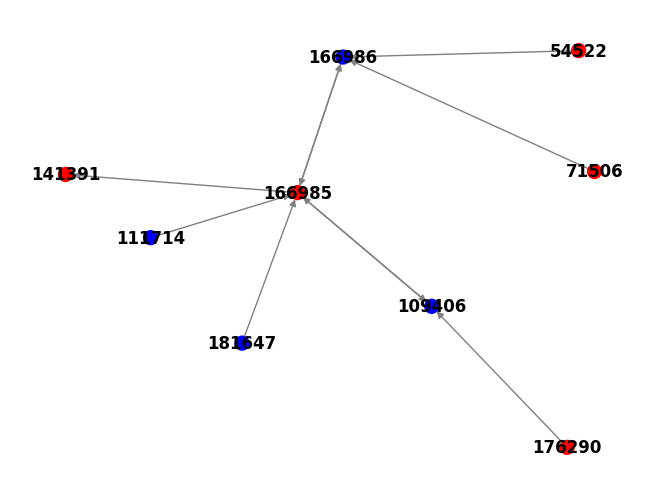

In [ ]:
pos = nx.spring_layout(subgraph )  # Positions for all nodes
nx.draw(subgraph, pos, node_color=colors, with_labels=True , font_weight='bold', node_size=100, font_size=12, edge_color='gray', width=1)
plt.show()

In [ ]:
adjacency_matrix = nx.adjacency_matrix(subgraph).toarray()
eigenvalues, eigenvectors = np.linalg.eig(adjacency_matrix)

<ipython-input-232-ef6ba42e8d64>:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(subgraph).toarray()


In [ ]:
k = 1
top_eigenvectors = eigenvectors[:, :k]

# Project data onto the subspace spanned by top eigenvectors
projected_data = np.dot(adjacency_matrix, top_eigenvectors)

# Reconstruct data from projected data
reconstructed_data = np.dot(projected_data, top_eigenvectors.T)
# Compute reconstruction error
reconstruction_error =np.linalg.norm(adjacency_matrix - reconstructed_data, axis=1)

# Define threshold for anomaly detection
threshold = 0.5  # Adjust as needed
# Detect anomalies
anomalies = [i for i, error in enumerate(reconstruction_error) if error > threshold]

print("Anomalies:", anomalies)


Anomalies: [0, 1, 2, 3, 4, 6, 7, 8]


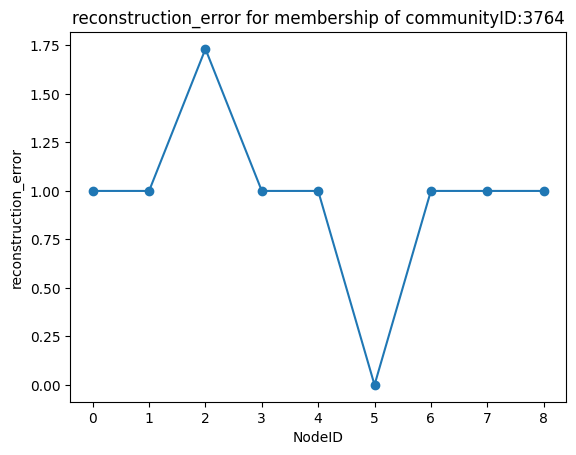

In [ ]:
AnomalNodelist=[]
for i, error in enumerate(reconstruction_error):
    item=[error]
    AnomalNodelist.append(item)
x = range(len(AnomalNodelist))

# Plot the values
plt.plot(x, AnomalNodelist, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('NodeID')
plt.ylabel('reconstruction_error')
plt.title('reconstruction_error for membership of communityID:3764')

# Show the plot
plt.show()

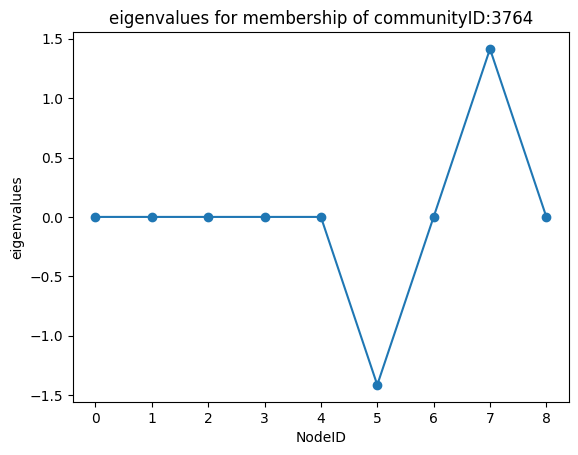

In [ ]:
x = range(len(eigenvalues))

# Plot the values
plt.plot(x, eigenvalues, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('NodeID')
plt.ylabel('eigenvalues')
plt.title('eigenvalues for membership of communityID:3764')

# Show the plot
plt.show()

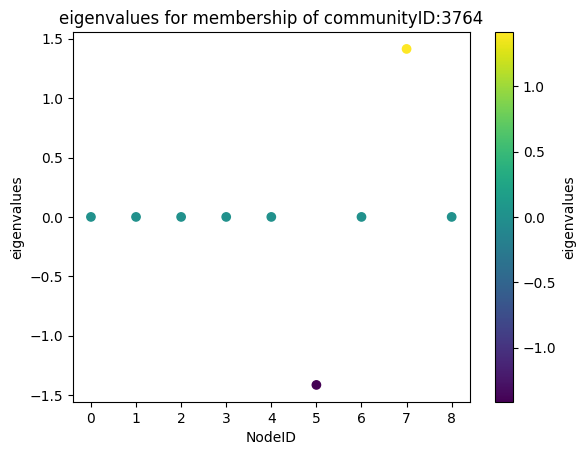

In [ ]:
AnomalNodelist=[]
for i, error in enumerate(reconstruction_error):
    item=[error]
    AnomalNodelist.append(item)
#------------------------------------------------------
x = range(len(eigenvalues))
cmap = plt.get_cmap('viridis')
plt.scatter(x, eigenvalues, c=eigenvalues, cmap=cmap)

# Add a colorbar
plt.colorbar(label='eigenvalues')

# Add labels and title
plt.xlabel('NodeID')
plt.ylabel('eigenvalues')
plt.title('eigenvalues for membership of communityID:3764')

# Show the plot
plt.show()

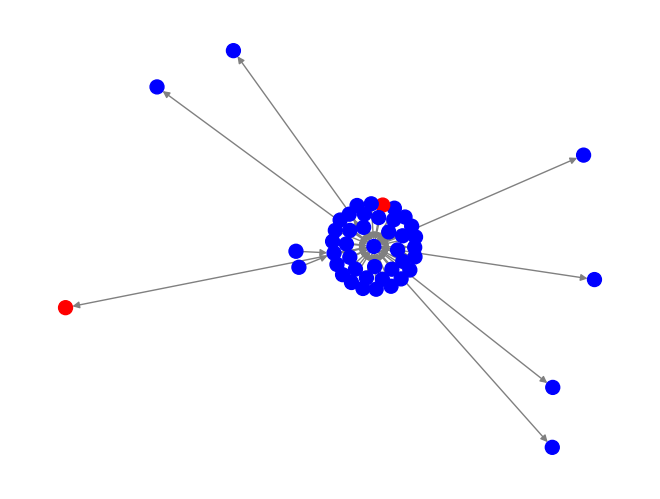

In [ ]:
subgraph_nodes = set(map(int, PartInfo[1980][1].strip('{}').split(',')))
subgraph=train_G.subgraph(subgraph_nodes)

#*****************************************************************
condition_column='NewNodeId'
condition_value=subgraph_nodes
#filtered_df =  nodedf[nodedf[condition_column].apply(lambda x: isinstance(subgraph_nodes, set))]
selected_rows = nodedf[nodedf[condition_column].isin(subgraph_nodes)]
#----------------------
labels_list = selected_rows['L_alert'].values.tolist()
labels_dict = {node: label for node, label in zip(subgraph.nodes, labels_list)}
nx.set_node_attributes(subgraph, labels_dict, 'label')

node_colors = {1: 'red', 0: 'blue'}
colors = [node_colors[subgraph.nodes[node]['label']] for node in subgraph.nodes]

#--------------------------

pos = nx.spring_layout(subgraph )  # Positions for all nodes
nx.draw(subgraph, pos, node_color=colors, with_labels=False , font_weight='bold', node_size=100, font_size=12, edge_color='gray', width=1)
plt.show()

In [ ]:
adjacency_matrix = nx.adjacency_matrix(subgraph).toarray()
eigenvalues, eigenvectors = np.linalg.eig(adjacency_matrix)
k = 1
top_eigenvectors = eigenvectors[:, :k]

# Project data onto the subspace spanned by top eigenvectors
projected_data = np.dot(adjacency_matrix, top_eigenvectors)

# Reconstruct data from projected data
reconstructed_data = np.dot(projected_data, top_eigenvectors.T)
# Compute reconstruction error
reconstruction_error =np.linalg.norm(adjacency_matrix - reconstructed_data, axis=1)

# Define threshold for anomaly detection
threshold = 0.1 # Adjust as needed
# Detect anomalies
anomalies = [i for i, error in enumerate(reconstruction_error) if error > threshold]

print("Anomalies:", anomalies)
print(len(anomalies))


Anomalies: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 44, 46, 47]
41


<ipython-input-284-6a9108d2ca32>:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(subgraph).toarray()


In [ ]:
normal_nodes = [i for i, eigenvalue in enumerate(eigenvalues) if eigenvalue >= threshold]
new_subgraph = subgraph.copy()
new_subgraph.remove_nodes_from(normal_nodes)
print(len(normal_nodes))


1


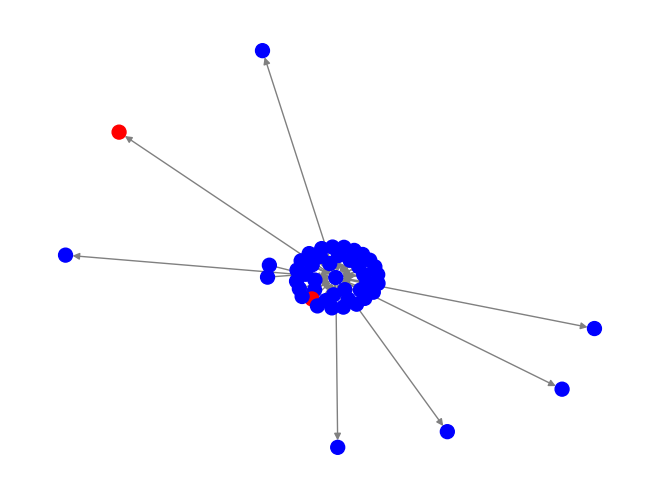

In [ ]:
subgraph_nodes_n=new_subgraph.nodes
condition_column='NewNodeId'
condition_value=subgraph_nodes
#filtered_df =  nodedf[nodedf[condition_column].apply(lambda x: isinstance(subgraph_nodes, set))]
selected_rows = nodedf[nodedf[condition_column].isin(subgraph_nodes_n)]
#----------------------
labels_list = selected_rows['L_alert'].values.tolist()
labels_dict = {node: label for node, label in zip(new_subgraph.nodes, labels_list)}
nx.set_node_attributes(subgraph, labels_dict, 'label')

node_colors = {1: 'red', 0: 'blue'}
colors = [node_colors[subgraph.nodes[node]['label']] for node in new_subgraph.nodes]

#--------------------------

pos = nx.spring_layout(new_subgraph )  # Positions for all nodes
nx.draw(subgraph, pos, node_color=colors, with_labels=False , font_weight='bold', node_size=100, font_size=12, edge_color='gray', width=1)
plt.show()

In [ ]:
AnomalNodelist=[]
for i, error in enumerate(reconstruction_error):
    item=[error]
    AnomalNodelist.append(item)


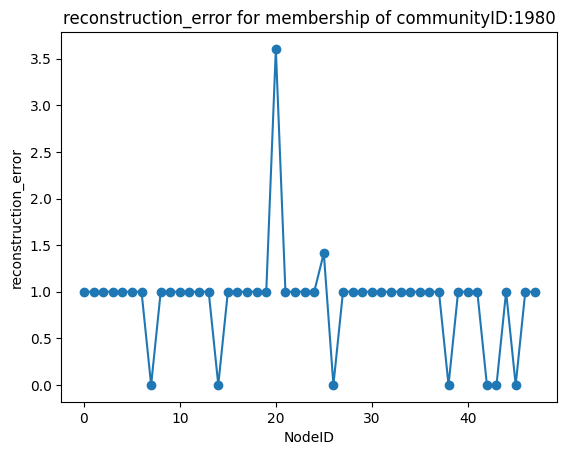

In [ ]:
x = range(len(AnomalNodelist))

# Plot the values
plt.plot(x, AnomalNodelist, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('NodeID')
plt.ylabel('reconstruction_error')
plt.title('reconstruction_error for membership of communityID:1980')

# Show the plot
plt.show()

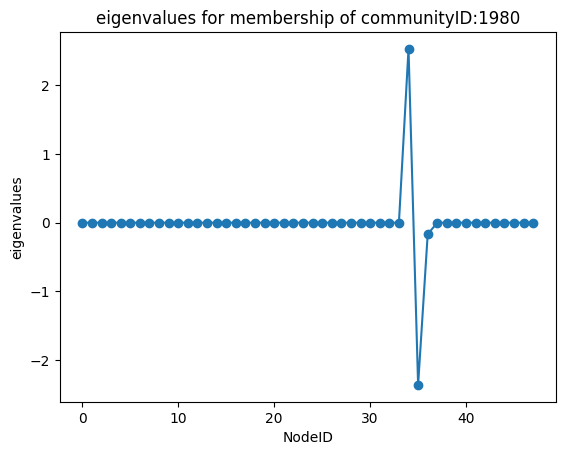

In [ ]:
x = range(len(eigenvalues))

# Plot the values
plt.plot(x, eigenvalues, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('NodeID')
plt.ylabel('eigenvalues')
plt.title('eigenvalues for membership of communityID:1980')

# Show the plot
plt.show()



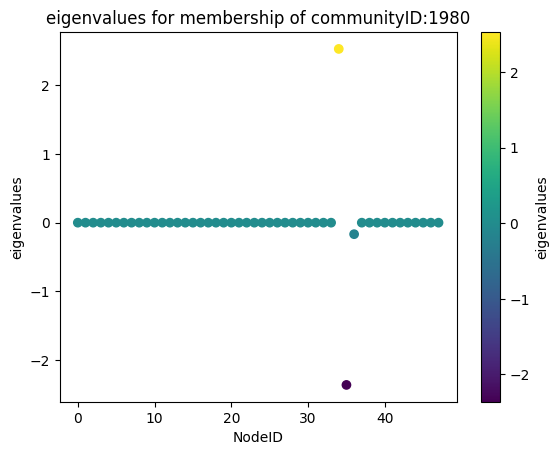

In [ ]:
x = range(len(eigenvalues))
cmap = plt.get_cmap('viridis')
plt.scatter(x, eigenvalues, c=eigenvalues, cmap=cmap)

# Add a colorbar
plt.colorbar(label='eigenvalues')

# Add labels and title
plt.xlabel('NodeID')
plt.ylabel('eigenvalues')
plt.title('eigenvalues for membership of communityID:1980')

# Show the plot
plt.show()

In [ ]:
#-------------------------------------------------------------------------------

In [ ]:
subgraph_nodes = set(map(int, PartInfo[154][1].strip('{}').split(',')))
subgraph=train_G.subgraph(subgraph_nodes)

In [ ]:
adjacency_matrix = nx.adjacency_matrix(subgraph).toarray()
eigenvalues, eigenvectors = np.linalg.eig(adjacency_matrix)
k = 1
top_eigenvectors = eigenvectors[:, :k]

# Project data onto the subspace spanned by top eigenvectors
projected_data = np.dot(adjacency_matrix, top_eigenvectors)

# Reconstruct data from projected data
reconstructed_data = np.dot(projected_data, top_eigenvectors.T)
# Compute reconstruction error
reconstruction_error =np.linalg.norm(adjacency_matrix - reconstructed_data, axis=1)

# Define threshold for anomaly detection
threshold = 0.5  # Adjust as needed
# Detect anomalies
anomalies = [i for i, error in enumerate(reconstruction_error) if error > threshold]

print("Anomalies:", anomalies)
print(len(anomalies))

<ipython-input-251-bcfda19c791c>:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(subgraph).toarray()


Anomalies: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 28, 29, 30, 31, 32, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 51, 52, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 94, 95, 96, 97, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134, 135, 136, 137, 139, 140, 141, 142, 143, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 185, 186, 188, 189, 190, 191, 192, 193, 194, 196, 197, 198, 201, 202, 203, 204, 205, 206, 208, 209, 211, 213, 215, 216, 217, 218, 219, 220, 221, 224, 225, 226, 227, 228, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 246, 247, 248, 249, 250, 251, 252, 253, 254, 256, 260, 261, 262, 26

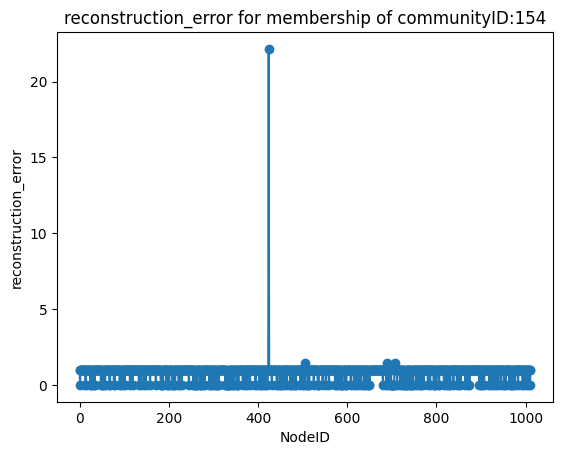

In [ ]:
AnomalNodelist=[]
for i, error in enumerate(reconstruction_error):
    item=[error]
    AnomalNodelist.append(item)
x = range(len(AnomalNodelist))

# Plot the values
plt.plot(x, AnomalNodelist, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('NodeID')
plt.ylabel('reconstruction_error')
plt.title('reconstruction_error for membership of communityID:154')

# Show the plot
plt.show()


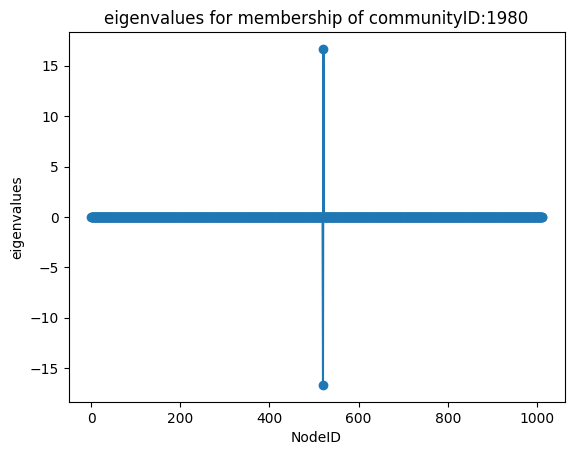

In [ ]:
x = range(len(eigenvalues))

# Plot the values
plt.plot(x, eigenvalues, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('NodeID')
plt.ylabel('eigenvalues')
plt.title('eigenvalues for membership of communityID:1980')

# Show the plot
plt.show()


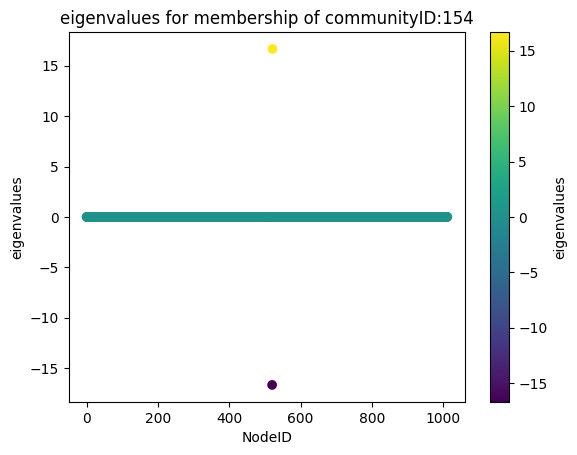

In [ ]:
x = range(len(eigenvalues))
cmap = plt.get_cmap('viridis')
plt.scatter(x, eigenvalues, c=eigenvalues, cmap=cmap)

# Add a colorbar
plt.colorbar(label='eigenvalues')

# Add labels and title
plt.xlabel('NodeID')
plt.ylabel('eigenvalues')
plt.title('eigenvalues for membership of communityID:154')

# Show the plot
plt.show()

# AccGrp Predict With Financial data :No1

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
Feature_train_df['f_amount_in_scaled'] = scaler.fit_transform(Feature_train_df[['f_amount_in']])
Feature_train_df['f_amount_out_scaled'] = scaler.fit_transform(Feature_train_df[['f_amount_out']])

Feature_train_df['f_nr_trans_in_scaled'] = scaler.fit_transform(Feature_train_df[['f_nr_trans_in']])
Feature_train_df['f_nr_trans_out_scaled'] = scaler.fit_transform(Feature_train_df[['f_nr_trans_out']])

Feature_test_df['f_amount_in_scaled'] = scaler.fit_transform(Feature_test_df[['f_amount_in']])
Feature_test_df['f_amount_out_scaled'] = scaler.fit_transform(Feature_test_df[['f_amount_out']])
Feature_test_df['f_nr_trans_in_scaled'] = scaler.fit_transform(Feature_test_df[['f_nr_trans_in']])
Feature_test_df['f_nr_trans_out_scaled'] = scaler.fit_transform(Feature_test_df[['f_nr_trans_out']])

In [ ]:
#featurename=['len_Community' ,'f_amount_in','f_amount_out','f_nr_trans_in','f_nr_trans_out']
#featurename=['f_amount_in','f_amount_out', 'f_nr_trans_in','f_nr_trans_out']
Col_Feature_Final=['f_amount_in_scaled','f_amount_out_scaled','f_nr_trans_in_scaled','f_nr_trans_out_scaled']
Grp_X_train=torch.tensor((Feature_train_df[Col_Feature_Final].values).tolist(), dtype=torch.float)
Grp_X_test =torch.tensor((Feature_test_df[Col_Feature_Final].values).tolist(), dtype=torch.float)
#Grp_X_train=torch.tensor(node_features_train)
#Grp_X_test=torch.tensor(node_features_test)
Grp_y_train=torch.tensor((Feature_train_df['Label'].values).tolist(), dtype=torch.long)
Grp_y_test=torch.tensor((Feature_test_df['Label'].values).tolist(), dtype=torch.long)

In [ ]:
len(Grp_X_train)

13767

In [ ]:
Grp_class_weights=Get_class_weights(Grp_y_train)

In [ ]:
batch_size_Grp =len(Grp_X_train)
batch_size_Grp_tst =len(Grp_X_test)
train_dateset=torch.utils.data.TensorDataset(Grp_X_train,Grp_y_train)
train_loader_Grp=torch.utils.data.DataLoader(train_dateset , batch_size=batch_size_Grp, shuffle=True)
test_dataset=torch.utils.data.TensorDataset(Grp_X_test,Grp_y_test)
test_loader_Grp=torch.utils.data.DataLoader(test_dataset , batch_size=batch_size_Grp_tst, shuffle=False )

In [ ]:
import tensorflow as tf
seed=42
learning_rate=0.03
num_classes=2
in_feats = Grp_X_train.shape[1]
hid_feats = 100 # Hidden layer size
out_feats = num_classes  # Number of output classes
num_heads =1

siamese_network = SiameseNetwork(eMRF_GAT,
                                 SAGE,
                                 in_channels=in_feats,
                                 hidden_channels=hid_feats,
                                 num_classes=num_classes,
                                 num_heads= num_heads,
                                 num_layers=1)



optimizer =torch.optim.Adam(siamese_network.parameters(), lr=learning_rate)

imbalance_ratio=8.3
class_weights = torch.tensor([1.5, imbalance_ratio])  # Adjust imbalance_ratio accordingly
#class_weights = class_weights.to(device)  # Move to GPU if available
class_weights = class_weights  # Move to GPU if available
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


num_epochs =100
tf.random.set_seed(42)
torch.manual_seed(seed)
np.random.seed(seed)

In epoch 0, loss: 0.930)
In epoch 5, loss: 0.550)
In epoch 10, loss: 0.437)
In epoch 15, loss: 0.314)
In epoch 20, loss: 0.256)
In epoch 25, loss: 0.247)
In epoch 30, loss: 0.230)
In epoch 35, loss: 0.222)
In epoch 40, loss: 0.214)
In epoch 45, loss: 0.200)
In epoch 50, loss: 0.196)
In epoch 55, loss: 0.194)
In epoch 60, loss: 0.194)
In epoch 65, loss: 0.207)
In epoch 70, loss: 0.186)
In epoch 75, loss: 0.185)
In epoch 80, loss: 0.185)
In epoch 85, loss: 0.185)
In epoch 90, loss: 0.181)
In epoch 95, loss: 0.183)


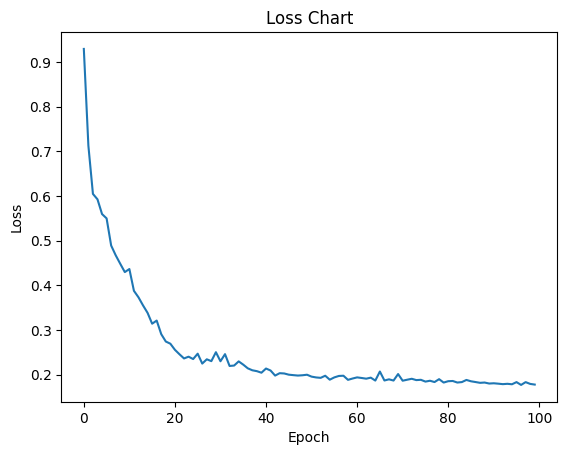

In [ ]:
torch.backends.cudnn.deterministic = True
Grp_model=train(model=siamese_network,
                train_loader=train_loader_Grp,
                epochs=num_epochs,
                class_weights=Grp_class_weights,
                learning_rate=learning_rate,
                edge_index=edge_index_TG,
                graph=Grp_train_graph)

              precision    recall  f1-score   support

           0       1.00      0.86      0.92      2041
           1       0.16      0.96      0.27        57

    accuracy                           0.86      2098
   macro avg       0.58      0.91      0.60      2098
weighted avg       0.98      0.86      0.90      2098



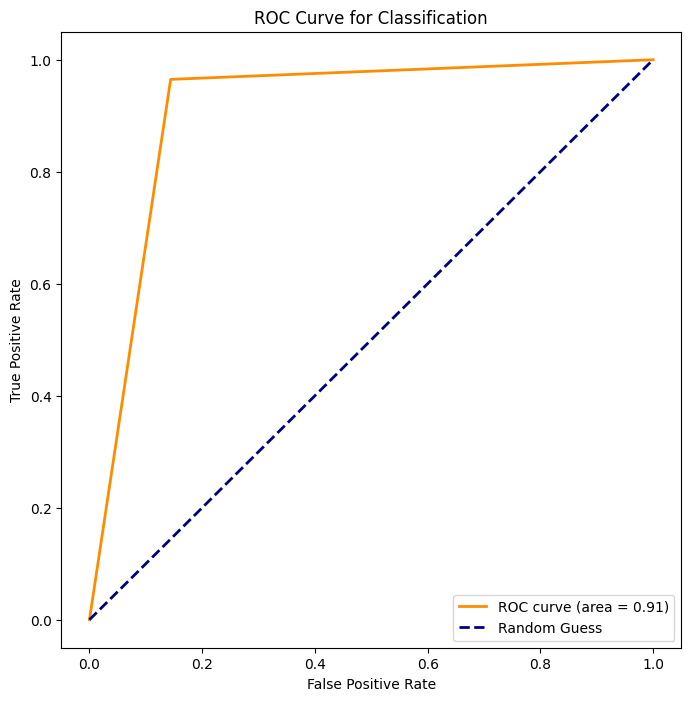

0.858913242816925

In [ ]:
evaluate(Grp_model, test_loader_Grp , edge_index_TST, Grp_test_graph)


# ACCGroup prediction with Subgraph embedding Feature

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
Feature_train_df['f_amount_in_scaled'] = scaler.fit_transform(Feature_train_df[['f_amount_in']])
Feature_train_df['f_amount_out_scaled'] = scaler.fit_transform(Feature_train_df[['f_amount_out']])


Feature_train_df['f_nr_trans_in_scaled'] = scaler.fit_transform(Feature_train_df[['f_nr_trans_in']])
Feature_train_df['f_nr_trans_out_scaled'] = scaler.fit_transform(Feature_train_df[['f_nr_trans_out']])

Feature_test_df['f_amount_in_scaled'] = scaler.fit_transform(Feature_test_df[['f_amount_in']])
Feature_test_df['f_amount_out_scaled'] = scaler.fit_transform(Feature_test_df[['f_amount_out']])
Feature_test_df['f_nr_trans_in_scaled'] = scaler.fit_transform(Feature_test_df[['f_nr_trans_in']])
Feature_test_df['f_nr_trans_out_scaled'] = scaler.fit_transform(Feature_test_df[['f_nr_trans_out']])


Col_Feature_Final=['f_amount_in_scaled','f_amount_out_scaled','f_nr_trans_in_scaled','f_nr_trans_out_scaled' , 'subgraph_embedding_0','subgraph_embedding_1' ]
#Col_Feature_Final=['f_amount_in_scaled','f_amount_out_scaled','subgraph_embedding_0','subgraph_embedding_1', 'embedded_Laplacian_0','embedded_Laplacian_1' ]
#Col_Feature_Final=['subgraph_embedding_0','subgraph_embedding_1', 'embedded_Laplacian_0','embedded_Laplacian_1' ]
Grp_X_train=torch.tensor((Feature_train_df[Col_Feature_Final].values).tolist(), dtype=torch.float)
Grp_X_test =torch.tensor((Feature_test_df[Col_Feature_Final].values).tolist(), dtype=torch.float)
Grp_y_train=torch.tensor((Feature_train_df['Label'].values).tolist(), dtype=torch.long)
Grp_y_test=torch.tensor((Feature_test_df['Label'].values).tolist(), dtype=torch.long)

In [ ]:
Grp_class_weights=Get_class_weights(Grp_y_train)

In [ ]:
batch_size_Grp =len(Grp_X_train)
batch_size_Grp_tst =len(Grp_X_test)
train_dateset=torch.utils.data.TensorDataset(Grp_X_train,Grp_y_train)
train_loader_Grp=torch.utils.data.DataLoader(train_dateset , batch_size=batch_size_Grp, shuffle=True)
test_dataset=torch.utils.data.TensorDataset(Grp_X_test,Grp_y_test)
test_loader_Grp=torch.utils.data.DataLoader(test_dataset , batch_size=batch_size_Grp_tst, shuffle=False )

In [ ]:
import tensorflow as tf
seed=42
learning_rate=0.02
num_classes=2
in_feats = Grp_X_train.shape[1]
hid_feats = 100 # Hidden layer size
out_feats = num_classes  # Number of output classes
num_heads =1

siamese_network = SiameseNetwork(eMRF_GAT,
                                 SAGE,
                                 in_channels=in_feats,
                                 hidden_channels=hid_feats,
                                 num_classes=num_classes,
                                 num_heads= num_heads,
                                 num_layers=1)



optimizer =torch.optim.Adam(siamese_network.parameters(), lr=learning_rate)

imbalance_ratio=8.3
class_weights = torch.tensor([1.5, imbalance_ratio])  # Adjust imbalance_ratio accordingly
#class_weights = class_weights.to(device)  # Move to GPU if available
class_weights = class_weights  # Move to GPU if available
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)


num_epochs =100
tf.random.set_seed(42)
torch.manual_seed(seed)
np.random.seed(seed)

In epoch 0, loss: 0.797)
In epoch 5, loss: 0.490)
In epoch 10, loss: 0.383)
In epoch 15, loss: 0.273)
In epoch 20, loss: 0.242)
In epoch 25, loss: 0.219)
In epoch 30, loss: 0.212)
In epoch 35, loss: 0.215)
In epoch 40, loss: 0.201)
In epoch 45, loss: 0.200)
In epoch 50, loss: 0.197)
In epoch 55, loss: 0.195)
In epoch 60, loss: 0.187)
In epoch 65, loss: 0.202)
In epoch 70, loss: 0.198)
In epoch 75, loss: 0.187)
In epoch 80, loss: 0.184)
In epoch 85, loss: 0.180)
In epoch 90, loss: 0.179)
In epoch 95, loss: 0.176)


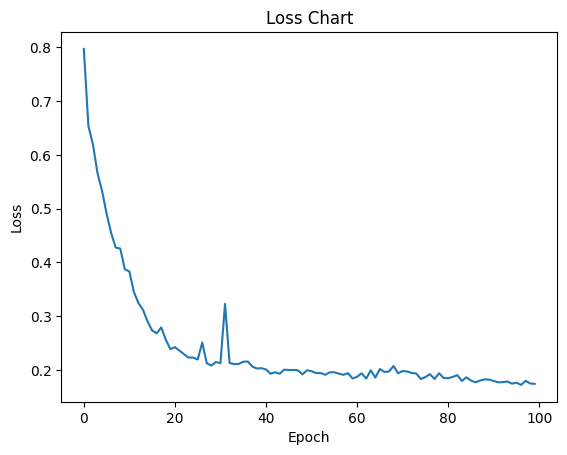

In [ ]:
torch.backends.cudnn.deterministic = True
Grp_model=train(model=siamese_network,
                train_loader=train_loader_Grp,
                epochs=num_epochs,
                class_weights=Grp_class_weights,
                learning_rate=learning_rate,
                edge_index=edge_index_TG,
                graph=Grp_train_graph)

              precision    recall  f1-score   support

           0       1.00      0.88      0.93      2041
           1       0.18      0.95      0.30        57

    accuracy                           0.88      2098
   macro avg       0.59      0.91      0.61      2098
weighted avg       0.98      0.88      0.92      2098



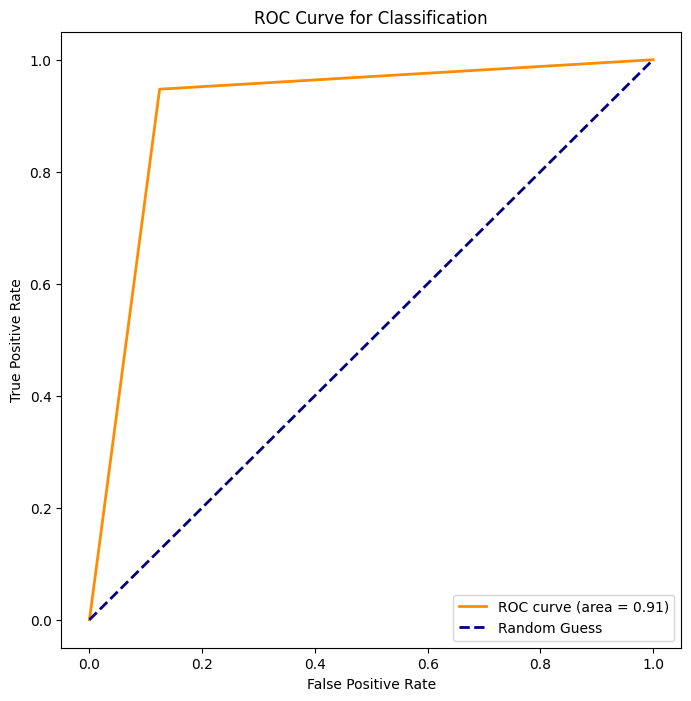

0.8775023818016052

In [ ]:
evaluate(Grp_model, test_loader_Grp , edge_index_TST, Grp_test_graph)